# Mullti-task Learning on Cifar100 Dataset: A CNN Approach
- Name: Minh T. Nguyen, Peter Chen
- ECE 6524 - Final Project
- Date: 4/14/2023
- **Objective**: Build a MTL model for image classification.
    - Task 1: Normal class classification (100 Classes).
    - Task 2: Superclass classification (20 Classes).
    
- **To Do**:
    - Experience with Different Model Configuration: 
        - Optimizers
        - Regularization: Dropout

In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt

# import tensorflow
import tensorflow as tf
from keras.datasets import cifar100
from keras.utils import np_utils, plot_model
from keras.layers import Input, Dropout, Flatten, Dense
from keras.applications.resnet import ResNet152, preprocess_input
from keras import Model

In [2]:
tf.version.VERSION

'2.11.0'

# 1. Data Visualization & Preprocessing

# 1.1 Data Visualization

In [3]:
# download data from Keras API
(X_train, y_train), (X_test, y_test) = cifar100.load_data()

169001437/169001437 [==============================] - 4s 0us/step


In [4]:
# check dataset size
print(f"X={X_train.shape}, y={y_train.shape}")
print(f"X={X_test.shape}, y={y_test.shape}")

X=(50000, 32, 32, 3), y=(50000, 1)
X=(10000, 32, 32, 3), y=(10000, 1)


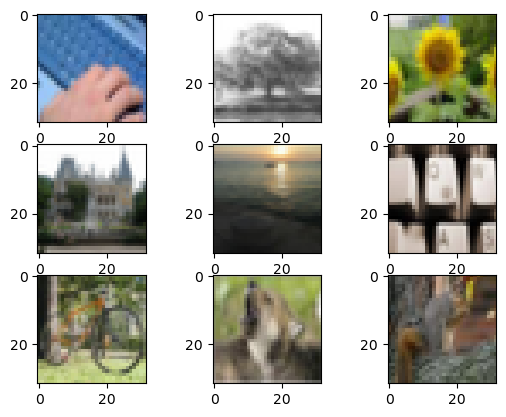

In [5]:
# plot the 9 images
f, axarr = plt.subplots(3,3)
axarr[0,0].imshow(X_train[10])
axarr[0,1].imshow(X_train[11])
axarr[0,2].imshow(X_train[12])
axarr[1,0].imshow(X_train[13])
axarr[1,1].imshow(X_train[14])
axarr[1,2].imshow(X_train[15])
axarr[2,0].imshow(X_train[16])
axarr[2,1].imshow(X_train[17])
axarr[2,2].imshow(X_train[18])
plt.show()

## 1.2. Creating Superclasses

**Superclass**
* aquatic mammals
* fish
* flowers
* food containers
* fruit and vegetables
* household electrical devices
* household furniture
* insects
* large carnivores
* large man-made outdoor things
* large natural outdoor scenes
* large omnivores and herbivores
* medium-sized mammals
* non-insect invertebrates
* people
* reptiles
* small mammals
* trees
* vehicles 1
* vehicles 2

In [6]:
# generate super-class of CIFAR100 dataset
(X_train_super, y_train_super), (X_test_super, y_test_super) = cifar100.load_data(label_mode = 'coarse')

In [7]:
# check labels for accuracy (referencing image plotted above)
print(y_train_super[10:19])

[[ 5]
 [17]
 [ 2]
 [ 9]
 [10]
 [ 5]
 [18]
 [ 8]
 [16]]


## 1.3. Data Processing

In [8]:
# normalize input data
X_train = preprocess_input(X_train)
X_test = preprocess_input(X_test)

print('X_train shape: ', X_train.shape)
print('X_test shape: ', X_test.shape)

# convert class into one hot encoder
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

print('\ny_train shape: ', y_train.shape)
print('y_test shape: ', y_test.shape)

# convert class into one hot encoder
y_train_super = np_utils.to_categorical(y_train_super)
y_test_super = np_utils.to_categorical(y_test_super)

print('\ny_train_super shape: ', y_train_super.shape)
print('y_test_super shape: ', y_test_super.shape)

X_train shape:  (50000, 32, 32, 3)
X_test shape:  (10000, 32, 32, 3)

y_train shape:  (50000, 100)
y_test shape:  (10000, 100)

y_train_super shape:  (50000, 20)
y_test_super shape:  (10000, 20)


# 2. Modeling

In [9]:
# Define ResNet152 CNN model
def create_model(dropout):
    input_shape = (32, 32, 3)
    
    resnet152_base = ResNet152(weights=None, include_top=False, input_shape=input_shape)
    
    
    # shared back-bone: convolution - feature extractor
    inputs = Input(shape=input_shape, name='input')
    shared_branch = resnet152_base(inputs)
    shared_branch = Flatten()(shared_branch)
    shared_branch = Dense(2048, activation='relu')(shared_branch)
    
    # task 1 branch - fully connected for 100-class classification
    task_1_branch = Dense(1024, activation='relu')(shared_branch)
    task_1_branch = Dropout(dropout)(task_1_branch) 
    task_1_branch = Dense(512, activation="relu")(task_1_branch)
    task_1_branch = Dense(256, activation="relu")(task_1_branch)
    task_1_branch = Dense(128, activation="relu")(task_1_branch)
    task_1_branch = Dense(100, activation="softmax", name="task_1_output")(task_1_branch)
    
    # task 1 branch - fully connected for 20-class superclass classification
    task_2_branch = Dense(512, activation='relu')(shared_branch)
    task_2_branch = Dropout(dropout)(task_2_branch)
    task_2_branch = Dense(256, activation="relu")(task_2_branch)
    task_2_branch = Dense(128, activation="relu")(task_2_branch)
    task_2_branch = Dense(20, activation="softmax", name="task_2_output")(task_2_branch)
    
    # modeling
    model = Model(inputs=inputs, outputs=[task_1_branch, task_2_branch])
    
    return model

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 resnet152 (Functional)         (None, 1, 1, 2048)   58370944    ['input[0][0]']                  
                                                                                                  
 flatten (Flatten)              (None, 2048)         0           ['resnet152[0][0]']              
                                                                                                  
 dense (Dense)                  (None, 2048)         4196352     ['flatten[0][0]']                
                                                                                              

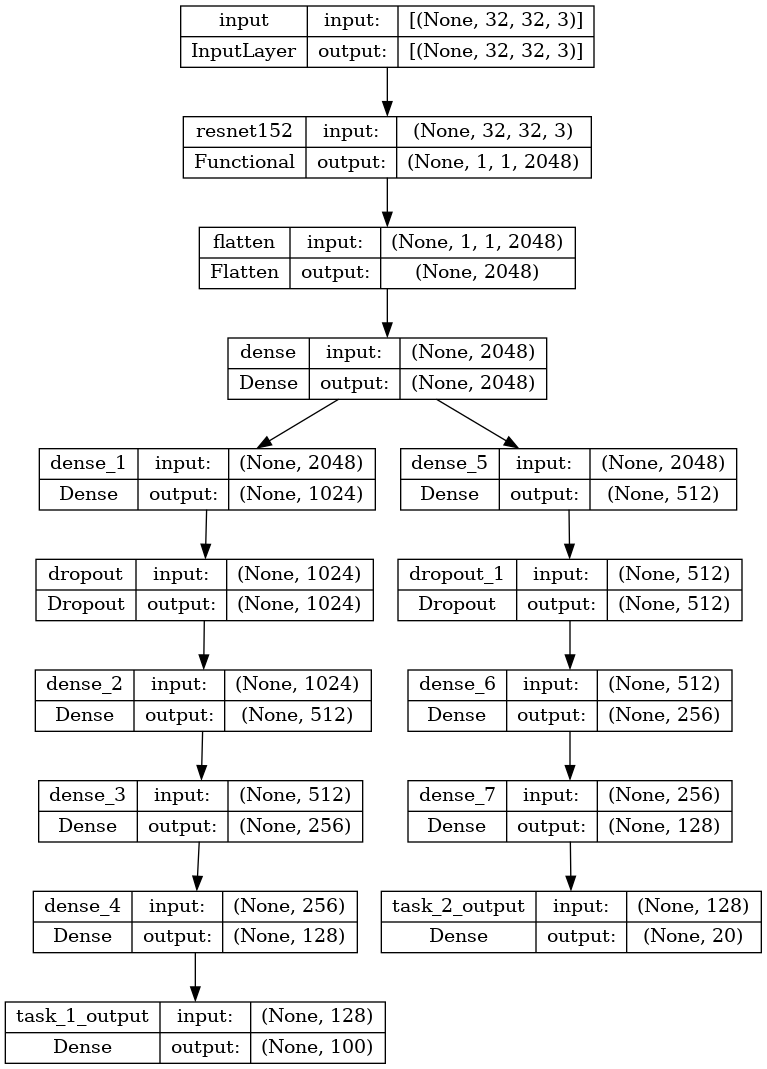

In [10]:
# display and plot model
model = create_model(0)
print(model.summary())
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [11]:
# define number of epochs and batch size
epochs = 20
batch_size = 256

## 2.1. Case 1: Gamma = 0.5 - The model will receive the loss evenly in both tasks
##      (Dropout = 0, Optimizer = Adam)

In [12]:
# define parameters and generate model
gamma=0.5
dropout = 0
optimizer = 'Adam'
model_1 = create_model(dropout)

In [13]:
# compile model
model_1.compile(loss={'task_1_output': 'categorical_crossentropy',
                    'task_2_output': 'categorical_crossentropy'},
              loss_weights={'task_1_output': gamma,
                            'task_2_output': 1-gamma},
              optimizer=optimizer,
              metrics=['accuracy'])

### Train & Evaluate Model

In [14]:
# train model
history_1 = model_1.fit({'input': X_train},
                        {'task_1_output': y_train, 'task_2_output': y_train_super}, 
                        validation_split=0.15,
                        epochs=epochs, 
                        batch_size=batch_size,
                        verbose=1)

Epoch 1/20
167/167 [==============================] - 142s 211ms/step - loss: 3.7181 - task_1_output_loss: 4.5097 - task_2_output_loss: 2.9265 - task_1_output_accuracy: 0.0192 - task_2_output_accuracy: 0.0866 - val_loss: 3.8274 - val_task_1_output_loss: 4.6424 - val_task_2_output_loss: 3.0125 - val_task_1_output_accuracy: 0.0081 - val_task_2_output_accuracy: 0.0527
Epoch 2/20
167/167 [==============================] - 32s 193ms/step - loss: 3.4626 - task_1_output_loss: 4.2319 - task_2_output_loss: 2.6933 - task_1_output_accuracy: 0.0313 - task_2_output_accuracy: 0.1347 - val_loss: 3.6066 - val_task_1_output_loss: 4.4074 - val_task_2_output_loss: 2.8057 - val_task_1_output_accuracy: 0.0280 - val_task_2_output_accuracy: 0.1151
Epoch 3/20
167/167 [==============================] - 32s 193ms/step - loss: 3.3722 - task_1_output_loss: 4.1365 - task_2_output_loss: 2.6079 - task_1_output_accuracy: 0.0392 - task_2_output_accuracy: 0.1605 - val_loss: 3.8488 - val_task_1_output_loss: 4.6310 - val

In [15]:
# train model results
print('Train loss:', history_1.history['loss'][-1])

print('\nTrain task 1 loss:', history_1.history['task_1_output_loss'][-1])
print('Train task 1 acc:', history_1.history['task_1_output_accuracy'][-1])

print('\nTrain task 2 loss:', history_1.history['task_2_output_loss'][-1])
print('Train task 2 acc:', history_1.history['task_2_output_accuracy'][-1])

Train loss: 2.937493085861206

Train task 1 loss: 3.6483566761016846
Train task 1 acc: 0.0962117612361908

Train task 2 loss: 2.2266311645507812
Train task 2 acc: 0.28661176562309265


### Evaluate Model

In [16]:
# test model results
evaluation_results = model_1.evaluate(
                        X_test, 
                        [y_test, y_test_super],
                        verbose=0)

In [17]:
# test model results
print('Test loss:', evaluation_results[0])

print('\nTest task 1 loss:', evaluation_results[1])
print('Test task 1 acc:', evaluation_results[3])

print('\nTest task 2 loss:', evaluation_results[2])
print('Test task 2 acc:', evaluation_results[4])

Test loss: 3.148968458175659

Test task 1 loss: 3.898850679397583
Test task 1 acc: 0.08129999786615372

Test task 2 loss: 2.3990824222564697
Test task 2 acc: 0.2468000054359436


### Plot Results

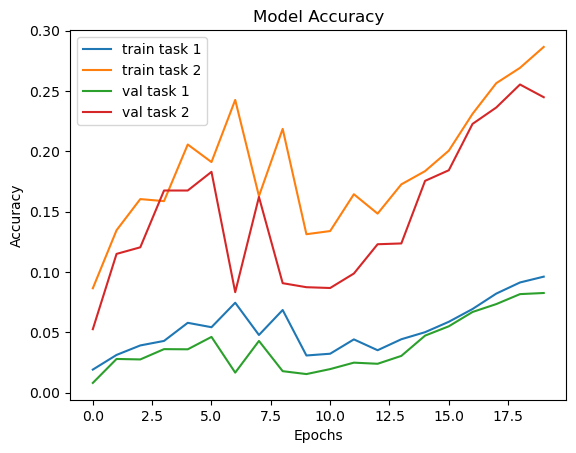

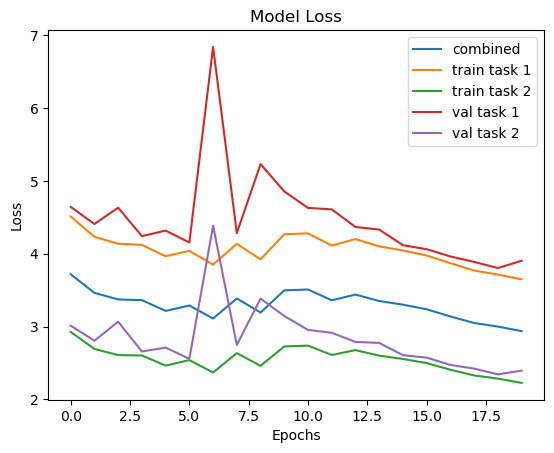

In [18]:
# accuracy plot
plt.plot(history_1.history['task_1_output_accuracy'])
plt.plot(history_1.history['task_2_output_accuracy'])
plt.plot(history_1.history['val_task_1_output_accuracy'])
plt.plot(history_1.history['val_task_2_output_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train task 1', 'train task 2', 'val task 1', 'val task 2'])
plt.show()

# loss plot
plt.plot(history_1.history['loss'])
plt.plot(history_1.history['task_1_output_loss'])
plt.plot(history_1.history['task_2_output_loss'])
plt.plot(history_1.history['val_task_1_output_loss'])
plt.plot(history_1.history['val_task_2_output_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['combined' ,'train task 1', 'train task 2', 'val task 1', 'val task 2'])
plt.show()

## 2.2. Case 2: Gamma = 0.6 - The model will receive loss 60% from task 1, 40% from task 2.
##      (Dropout = 0, Optimizer = Adam)

### Get Model

In [19]:
# define parameters and generate model
gamma=0.6
dropout = 0
optimizer = 'Adam'
model_2 = create_model(dropout)

In [20]:
# compile model
model_2.compile(loss={'task_1_output': 'categorical_crossentropy',
                    'task_2_output': 'categorical_crossentropy'},
              loss_weights={'task_1_output': gamma,
                            'task_2_output': 1-gamma},
              optimizer=optimizer,
              metrics=['accuracy'])

### Train & Evaluate Model

In [21]:
# train model
history_2 = model_2.fit({'input': X_train},
                        {'task_1_output': y_train, 'task_2_output': y_train_super}, 
                        validation_split=0.15,
                        epochs=epochs, 
                        batch_size=batch_size,
                        verbose=1)

Epoch 1/20
167/167 [==============================] - 139s 207ms/step - loss: 3.8461 - task_1_output_loss: 4.4956 - task_2_output_loss: 2.8718 - task_1_output_accuracy: 0.0189 - task_2_output_accuracy: 0.0942 - val_loss: 3.9277 - val_task_1_output_loss: 4.5709 - val_task_2_output_loss: 2.9628 - val_task_1_output_accuracy: 0.0159 - val_task_2_output_accuracy: 0.0661
Epoch 2/20
167/167 [==============================] - 31s 189ms/step - loss: 3.6675 - task_1_output_loss: 4.2864 - task_2_output_loss: 2.7391 - task_1_output_accuracy: 0.0295 - task_2_output_accuracy: 0.1207 - val_loss: 3.9418 - val_task_1_output_loss: 4.5792 - val_task_2_output_loss: 2.9858 - val_task_1_output_accuracy: 0.0180 - val_task_2_output_accuracy: 0.0844
Epoch 3/20
167/167 [==============================] - 32s 194ms/step - loss: 3.6179 - task_1_output_loss: 4.2309 - task_2_output_loss: 2.6983 - task_1_output_accuracy: 0.0350 - task_2_output_accuracy: 0.1305 - val_loss: 3.6246 - val_task_1_output_loss: 4.2357 - val

In [22]:
# train model results
print('Train loss:', history_2.history['loss'][-1])

print('\nTrain task 1 loss:', history_2.history['task_1_output_loss'][-1])
print('Train task 1 acc:', history_2.history['task_1_output_accuracy'][-1])

print('\nTrain task 2 loss:', history_2.history['task_2_output_loss'][-1])
print('Train task 2 acc:', history_2.history['task_2_output_accuracy'][-1])

Train loss: 2.1953909397125244

Train task 1 loss: 2.6669774055480957
Train task 1 acc: 0.27498823404312134

Train task 2 loss: 1.4880108833312988
Train task 2 acc: 0.5191764831542969


### Evaluate Model

In [23]:
# test model results
evaluation_results = model_2.evaluate(
                        X_test, 
                        [y_test, y_test_super],
                        verbose=0)

In [24]:
# test model results
print('Test loss:', evaluation_results[0])

print('\nTest task 1 loss:', evaluation_results[1])
print('Test task 1 acc:', evaluation_results[3])

print('\nTest task 2 loss:', evaluation_results[2])
print('Test task 2 acc:', evaluation_results[4])

Test loss: 3.5084190368652344

Test task 1 loss: 4.116884708404541
Test task 1 acc: 0.10970000177621841

Test task 2 loss: 2.5957186222076416
Test task 2 acc: 0.26930001378059387


### Plot Results

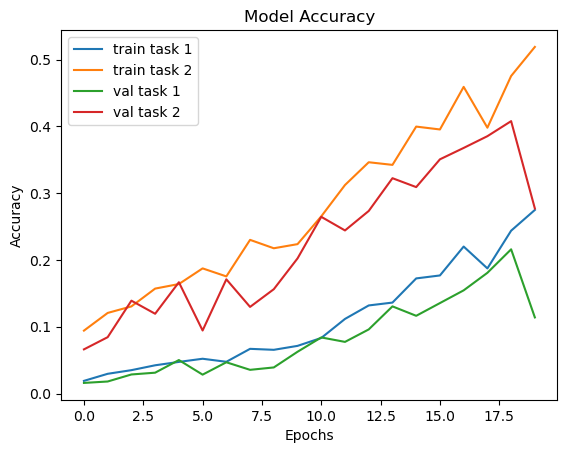

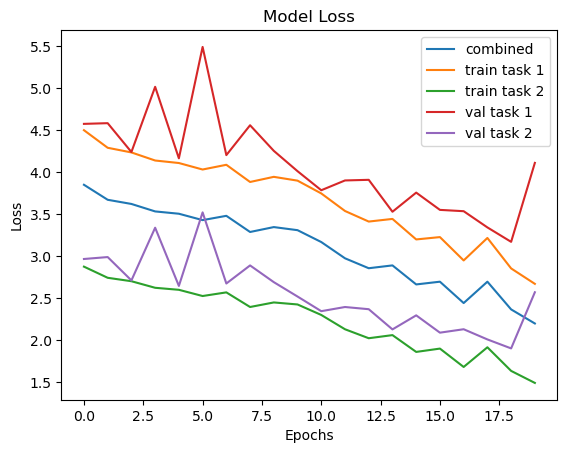

In [25]:
# accuracy plot
plt.plot(history_2.history['task_1_output_accuracy'])
plt.plot(history_2.history['task_2_output_accuracy'])
plt.plot(history_2.history['val_task_1_output_accuracy'])
plt.plot(history_2.history['val_task_2_output_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train task 1', 'train task 2', 'val task 1', 'val task 2'])
plt.show()

# loss plot
plt.plot(history_2.history['loss'])
plt.plot(history_2.history['task_1_output_loss'])
plt.plot(history_2.history['task_2_output_loss'])
plt.plot(history_2.history['val_task_1_output_loss'])
plt.plot(history_2.history['val_task_2_output_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['combined' ,'train task 1', 'train task 2', 'val task 1', 'val task 2'])
plt.show()

## 2.3. Case 3: Gamma = 0.4 - The model will receive loss 40% from task 1, 60% from task 2.
##      (Dropout = 0, Optimizer = Adam)

In [26]:
# define parameters and generate model
gamma=0.4
dropout = 0
optimizer = 'Adam'
model_3 = create_model(dropout)

In [27]:
# compile model
model_3.compile(loss={'task_1_output': 'categorical_crossentropy',
                    'task_2_output': 'categorical_crossentropy'},
              loss_weights={'task_1_output': gamma,
                            'task_2_output': 1-gamma},
              optimizer=optimizer,
              metrics=['accuracy'])

### Train & Evaluate Model

In [28]:
# train model
history_3 = model_3.fit({'input': X_train},
                        {'task_1_output': y_train, 'task_2_output': y_train_super}, 
                        validation_split=0.15,
                        epochs=epochs, 
                        batch_size=batch_size,
                        verbose=1)

Epoch 1/20
167/167 [==============================] - 137s 213ms/step - loss: 3.5207 - task_1_output_loss: 4.4709 - task_2_output_loss: 2.8873 - task_1_output_accuracy: 0.0202 - task_2_output_accuracy: 0.0974 - val_loss: 4.1617 - val_task_1_output_loss: 5.2923 - val_task_2_output_loss: 3.4080 - val_task_1_output_accuracy: 0.0109 - val_task_2_output_accuracy: 0.0521
Epoch 2/20
167/167 [==============================] - 32s 194ms/step - loss: 3.3808 - task_1_output_loss: 4.3111 - task_2_output_loss: 2.7606 - task_1_output_accuracy: 0.0316 - task_2_output_accuracy: 0.1165 - val_loss: 3.3271 - val_task_1_output_loss: 4.2466 - val_task_2_output_loss: 2.7142 - val_task_1_output_accuracy: 0.0320 - val_task_2_output_accuracy: 0.1259
Epoch 3/20
167/167 [==============================] - 31s 188ms/step - loss: 3.2592 - task_1_output_loss: 4.1749 - task_2_output_loss: 2.6488 - task_1_output_accuracy: 0.0379 - task_2_output_accuracy: 0.1416 - val_loss: 25.3107 - val_task_1_output_loss: 33.9921 - v

In [29]:
# train model results
print('Train loss:', history_3.history['loss'][-1])

print('\nTrain task 1 loss:', history_3.history['task_1_output_loss'][-1])
print('Train task 1 acc:', history_3.history['task_1_output_accuracy'][-1])

print('\nTrain task 2 loss:', history_3.history['task_2_output_loss'][-1])
print('Train task 2 acc:', history_3.history['task_2_output_accuracy'][-1])

Train loss: 2.135382652282715

Train task 1 loss: 2.9354820251464844
Train task 1 acc: 0.20623528957366943

Train task 2 loss: 1.6019823551177979
Train task 2 acc: 0.479694128036499


### Evaluate Model

In [30]:
# test model results
evaluation_results = model_3.evaluate(
                        X_test, 
                        [y_test, y_test_super],
                        verbose=0)

In [31]:
# test model results
print('Test loss:', evaluation_results[0])

print('\nTest task 1 loss:', evaluation_results[1])
print('Test task 1 acc:', evaluation_results[3])

print('\nTest task 2 loss:', evaluation_results[2])
print('Test task 2 acc:', evaluation_results[4])

Test loss: 2.7942659854888916

Test task 1 loss: 3.6367125511169434
Test task 1 acc: 0.14669999480247498

Test task 2 loss: 2.2326362133026123
Test task 2 acc: 0.34549999237060547


### Plot Results

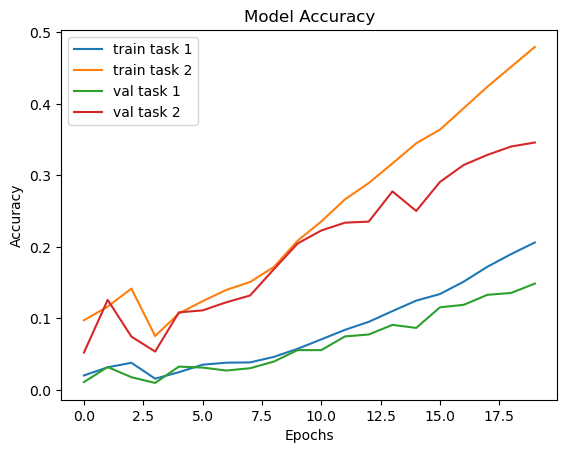

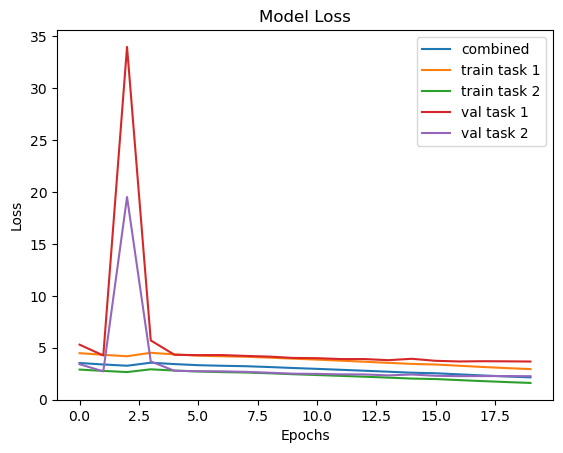

In [32]:
# accuracy plot
plt.plot(history_3.history['task_1_output_accuracy'])
plt.plot(history_3.history['task_2_output_accuracy'])
plt.plot(history_3.history['val_task_1_output_accuracy'])
plt.plot(history_3.history['val_task_2_output_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train task 1', 'train task 2', 'val task 1', 'val task 2'])
plt.show()

# loss plot
plt.plot(history_3.history['loss'])
plt.plot(history_3.history['task_1_output_loss'])
plt.plot(history_3.history['task_2_output_loss'])
plt.plot(history_3.history['val_task_1_output_loss'])
plt.plot(history_3.history['val_task_2_output_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['combined' ,'train task 1', 'train task 2', 'val task 1', 'val task 2'])
plt.show()

## 2.4. Case 4: Gamma = 0.5 - The model will receive loss evenly from task 1 and task 2.
##      (Dropout = 0.5, Optimizer = Adam)

In [33]:
# define parameters and generate model
gamma=0.5
dropout = 0.5
optimizer = 'Adam'
model_4 = create_model(dropout)

In [34]:
# compile model
model_4.compile(loss={'task_1_output': 'categorical_crossentropy',
                    'task_2_output': 'categorical_crossentropy'},
              loss_weights={'task_1_output': gamma,
                            'task_2_output': 1-gamma},
              optimizer=optimizer,
              metrics=['accuracy'])

### Train & Evaluate Model

In [35]:
# train model
history_4 = model_4.fit({'input': X_train},
                        {'task_1_output': y_train, 'task_2_output': y_train_super}, 
                        validation_split=0.15,
                        epochs=epochs, 
                        batch_size=batch_size,
                        verbose=1)

Epoch 1/20
167/167 [==============================] - 138s 213ms/step - loss: 3.7944 - task_1_output_loss: 4.5851 - task_2_output_loss: 3.0036 - task_1_output_accuracy: 0.0139 - task_2_output_accuracy: 0.0691 - val_loss: 3.8122 - val_task_1_output_loss: 4.6255 - val_task_2_output_loss: 2.9988 - val_task_1_output_accuracy: 0.0092 - val_task_2_output_accuracy: 0.0485
Epoch 2/20
167/167 [==============================] - 32s 194ms/step - loss: 3.5585 - task_1_output_loss: 4.3378 - task_2_output_loss: 2.7792 - task_1_output_accuracy: 0.0250 - task_2_output_accuracy: 0.1099 - val_loss: 3.6310 - val_task_1_output_loss: 4.4051 - val_task_2_output_loss: 2.8569 - val_task_1_output_accuracy: 0.0220 - val_task_2_output_accuracy: 0.0941
Epoch 3/20
167/167 [==============================] - 33s 194ms/step - loss: 3.4846 - task_1_output_loss: 4.2484 - task_2_output_loss: 2.7208 - task_1_output_accuracy: 0.0312 - task_2_output_accuracy: 0.1252 - val_loss: 3.5756 - val_task_1_output_loss: 4.3578 - val

In [36]:
# train model results
print('Train loss:', history_4.history['loss'][-1])

print('\nTrain task 1 loss:', history_4.history['task_1_output_loss'][-1])
print('Train task 1 acc:', history_4.history['task_1_output_accuracy'][-1])

print('\nTrain task 2 loss:', history_4.history['task_2_output_loss'][-1])
print('Train task 2 acc:', history_4.history['task_2_output_accuracy'][-1])

Train loss: 2.300287961959839

Train task 1 loss: 2.9158427715301514
Train task 1 acc: 0.22456470131874084

Train task 2 loss: 1.684733510017395
Train task 2 acc: 0.4524235427379608


### Evaluate Model

In [37]:
# test model results
evaluation_results = model_4.evaluate(
                        X_test, 
                        [y_test, y_test_super],
                        verbose=0)

In [38]:
# test model results
print('Test loss:', evaluation_results[0])

print('\nTest task 1 loss:', evaluation_results[1])
print('Test task 1 acc:', evaluation_results[3])

print('\nTest task 2 loss:', evaluation_results[2])
print('Test task 2 acc:', evaluation_results[4])

Test loss: 2.7093758583068848

Test task 1 loss: 3.374927043914795
Test task 1 acc: 0.1673000007867813

Test task 2 loss: 2.0438265800476074
Test task 2 acc: 0.3626999855041504


### Plot Results

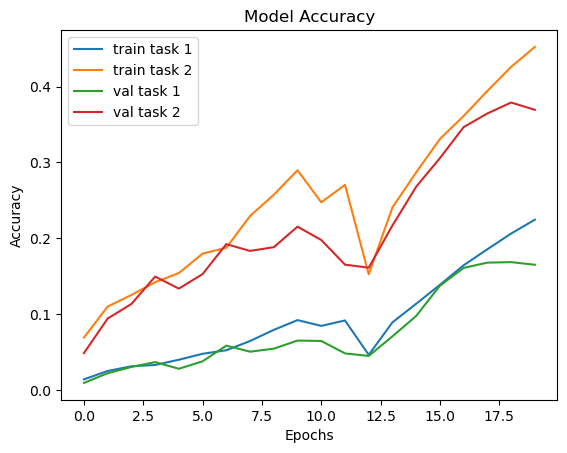

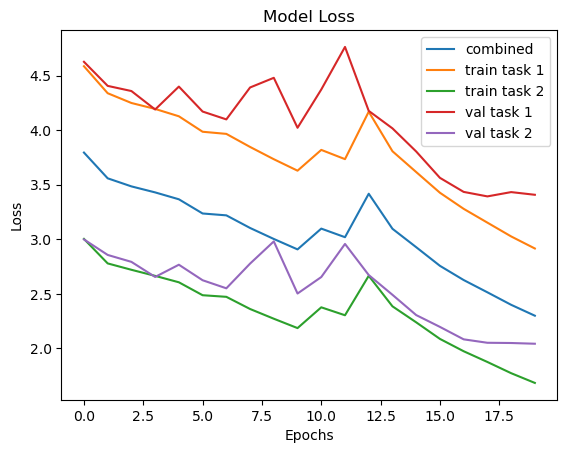

In [39]:
# accuracy plot
plt.plot(history_4.history['task_1_output_accuracy'])
plt.plot(history_4.history['task_2_output_accuracy'])
plt.plot(history_4.history['val_task_1_output_accuracy'])
plt.plot(history_4.history['val_task_2_output_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train task 1', 'train task 2', 'val task 1', 'val task 2'])
plt.show()

# loss plot
plt.plot(history_4.history['loss'])
plt.plot(history_4.history['task_1_output_loss'])
plt.plot(history_4.history['task_2_output_loss'])
plt.plot(history_4.history['val_task_1_output_loss'])
plt.plot(history_4.history['val_task_2_output_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['combined' ,'train task 1', 'train task 2', 'val task 1', 'val task 2'])
plt.show()

## 2.5. Case 5: Gamma = 0.5 - The model will receive loss evenly from task 1 and task 2.
##      (Dropout = 0.5, Optimizer = SGD)

In [40]:
# define parameters and generate model
gamma=0.5
dropout = 0.5
optimizer = 'SGD'
model_5 = create_model(dropout)

In [41]:
# compile model
model_5.compile(loss={'task_1_output': 'categorical_crossentropy',
                    'task_2_output': 'categorical_crossentropy'},
              loss_weights={'task_1_output': gamma,
                            'task_2_output': 1-gamma},
              optimizer=optimizer,
              metrics=['accuracy'])

### Train & Evaluate Model

In [42]:
# train model
history_5 = model_5.fit({'input': X_train},
                        {'task_1_output': y_train, 'task_2_output': y_train_super}, 
                        validation_split=0.15,
                        epochs=epochs, 
                        batch_size=batch_size,
                        verbose=1)

Epoch 1/20
167/167 [==============================] - 79s 201ms/step - loss: 3.8585 - task_1_output_loss: 4.6546 - task_2_output_loss: 3.0623 - task_1_output_accuracy: 0.0115 - task_2_output_accuracy: 0.0561 - val_loss: 4086001565696.0000 - val_task_1_output_loss: 4256684572672.0000 - val_task_2_output_loss: 3915319607296.0000 - val_task_1_output_accuracy: 0.0097 - val_task_2_output_accuracy: 0.0489
Epoch 2/20
167/167 [==============================] - 31s 187ms/step - loss: 3.7944 - task_1_output_loss: 4.6009 - task_2_output_loss: 2.9879 - task_1_output_accuracy: 0.0133 - task_2_output_accuracy: 0.0683 - val_loss: 9.1508 - val_task_1_output_loss: 12.2730 - val_task_2_output_loss: 6.0285 - val_task_1_output_accuracy: 0.0088 - val_task_2_output_accuracy: 0.0464
Epoch 3/20
167/167 [==============================] - 30s 180ms/step - loss: 3.7797 - task_1_output_loss: 4.5914 - task_2_output_loss: 2.9679 - task_1_output_accuracy: 0.0132 - task_2_output_accuracy: 0.0727 - val_loss: 7.0143 - 

In [43]:
# train model results
print('Train loss:', history_5.history['loss'][-1])

print('\nTrain task 1 loss:', history_5.history['task_1_output_loss'][-1])
print('Train task 1 acc:', history_5.history['task_1_output_accuracy'][-1])

print('\nTrain task 2 loss:', history_5.history['task_2_output_loss'][-1])
print('Train task 2 acc:', history_5.history['task_2_output_accuracy'][-1])

Train loss: 3.4140448570251465

Train task 1 loss: 4.184203147888184
Train task 1 acc: 0.042141176760196686

Train task 2 loss: 2.643885850906372
Train task 2 acc: 0.15515294671058655


### Evaluate Model

In [44]:
# test model results
evaluation_results = model_5.evaluate(
                        X_test, 
                        [y_test, y_test_super],
                        verbose=0)

In [45]:
# test model results
print('Test loss:', evaluation_results[0])

print('\nTest task 1 loss:', evaluation_results[1])
print('Test task 1 acc:', evaluation_results[3])

print('\nTest task 2 loss:', evaluation_results[2])
print('Test task 2 acc:', evaluation_results[4])

Test loss: 14.449333190917969

Test task 1 loss: 15.552438735961914
Test task 1 acc: 0.01510000042617321

Test task 2 loss: 13.34621524810791
Test task 2 acc: 0.06430000066757202


### Plot Results

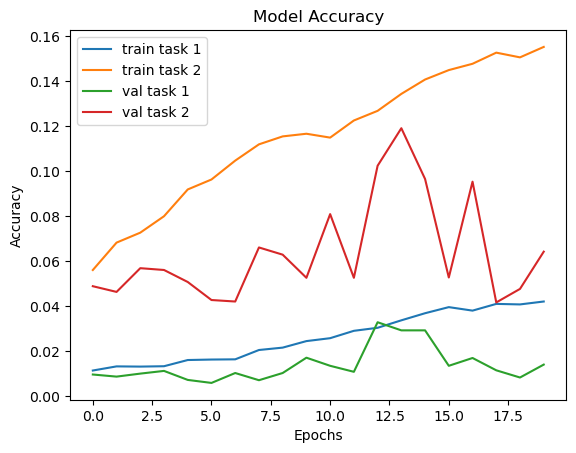

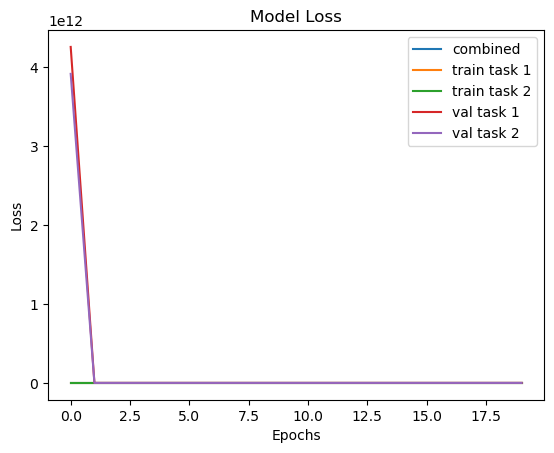

In [46]:
# accuracy plot
plt.plot(history_5.history['task_1_output_accuracy'])
plt.plot(history_5.history['task_2_output_accuracy'])
plt.plot(history_5.history['val_task_1_output_accuracy'])
plt.plot(history_5.history['val_task_2_output_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train task 1', 'train task 2', 'val task 1', 'val task 2'])
plt.show()

# loss plot
plt.plot(history_5.history['loss'])
plt.plot(history_5.history['task_1_output_loss'])
plt.plot(history_5.history['task_2_output_loss'])
plt.plot(history_5.history['val_task_1_output_loss'])
plt.plot(history_5.history['val_task_2_output_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['combined' ,'train task 1', 'train task 2', 'val task 1', 'val task 2'])
plt.show()

## 2.6. Case 6: Gamma = 1 - The model will receive the loss from task 1 only
##      (Dropout = 0, Optimizer = Adam)

In [47]:
# define parameters and generate model
gamma = 1
dropout = 0
optimizer = 'Adam'
model_6 = create_model(dropout)

In [48]:
# compile model
model_6.compile(loss={'task_1_output': 'categorical_crossentropy',
                    'task_2_output': 'categorical_crossentropy'},
              loss_weights={'task_1_output': gamma,
                            'task_2_output': 1-gamma},
              optimizer=optimizer,
              metrics=['accuracy'])

### Train & Evaluate Model

In [49]:
# train model
history_6 = model_1.fit({'input': X_train},
                        {'task_1_output': y_train, 'task_2_output': y_train_super}, 
                        validation_split=0.15,
                        epochs=epochs, 
                        batch_size=batch_size,
                        verbose=1)

Epoch 1/20
167/167 [==============================] - 32s 194ms/step - loss: 2.8494 - task_1_output_loss: 3.5572 - task_2_output_loss: 2.1416 - task_1_output_accuracy: 0.1104 - task_2_output_accuracy: 0.3131 - val_loss: 3.1726 - val_task_1_output_loss: 3.8980 - val_task_2_output_loss: 2.4472 - val_task_1_output_accuracy: 0.0843 - val_task_2_output_accuracy: 0.2465
Epoch 2/20
167/167 [==============================] - 32s 192ms/step - loss: 3.1786 - task_1_output_loss: 3.8931 - task_2_output_loss: 2.4641 - task_1_output_accuracy: 0.0819 - task_2_output_accuracy: 0.2262 - val_loss: 3.1666 - val_task_1_output_loss: 3.8830 - val_task_2_output_loss: 2.4502 - val_task_1_output_accuracy: 0.0825 - val_task_2_output_accuracy: 0.2329
Epoch 3/20
167/167 [==============================] - 31s 185ms/step - loss: 3.0007 - task_1_output_loss: 3.6946 - task_2_output_loss: 2.3067 - task_1_output_accuracy: 0.1049 - task_2_output_accuracy: 0.2714 - val_loss: 3.0410 - val_task_1_output_loss: 3.7522 - val_

In [50]:
# train model results
print('Train loss:', history_6.history['loss'][-1])

print('\nTrain task 1 loss:', history_6.history['task_1_output_loss'][-1])
print('Train task 1 acc:', history_6.history['task_1_output_accuracy'][-1])

print('\nTrain task 2 loss:', history_6.history['task_2_output_loss'][-1])
print('Train task 2 acc:', history_6.history['task_2_output_accuracy'][-1])

Train loss: 1.5330809354782104

Train task 1 loss: 2.09332013130188
Train task 1 acc: 0.3736705780029297

Train task 2 loss: 0.9728409647941589
Train task 2 acc: 0.682941198348999


### Evaluate Model

In [51]:
# test model results
evaluation_results = model_6.evaluate(
                        X_test, 
                        [y_test, y_test_super],
                        verbose=0)

In [52]:
# test model results
print('Test loss:', evaluation_results[0])

print('\nTest task 1 loss:', evaluation_results[1])
print('Test task 1 acc:', evaluation_results[3])

print('\nTest task 2 loss:', evaluation_results[2])
print('Test task 2 acc:', evaluation_results[4])

Test loss: 7.865411758422852

Test task 1 loss: 7.865411758422852
Test task 1 acc: 0.009999999776482582

Test task 2 loss: 7.496148586273193
Test task 2 acc: 0.05950000137090683


### Plot Results

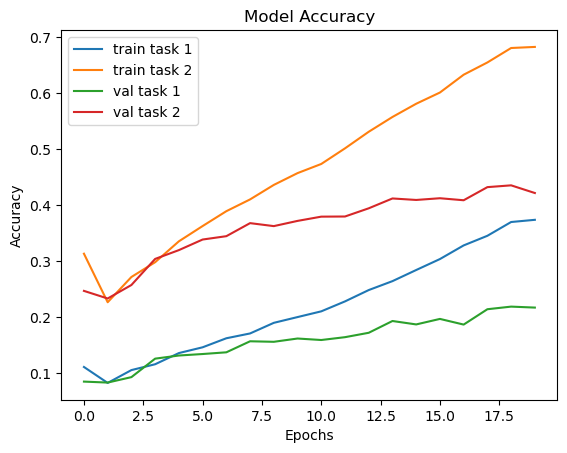

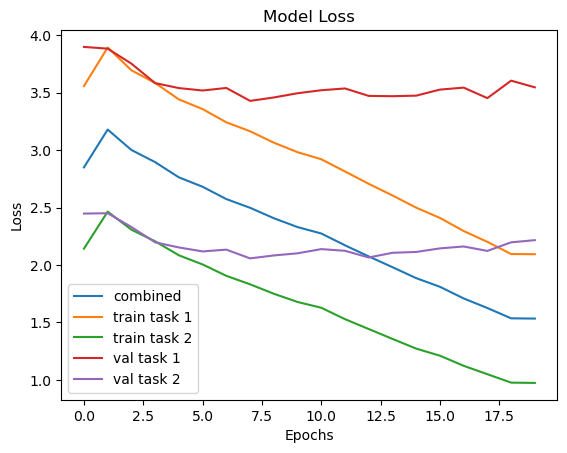

In [53]:
# accuracy plot
plt.plot(history_6.history['task_1_output_accuracy'])
plt.plot(history_6.history['task_2_output_accuracy'])
plt.plot(history_6.history['val_task_1_output_accuracy'])
plt.plot(history_6.history['val_task_2_output_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train task 1', 'train task 2', 'val task 1', 'val task 2'])
plt.show()

# loss plot
plt.plot(history_6.history['loss'])
plt.plot(history_6.history['task_1_output_loss'])
plt.plot(history_6.history['task_2_output_loss'])
plt.plot(history_6.history['val_task_1_output_loss'])
plt.plot(history_6.history['val_task_2_output_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['combined' ,'train task 1', 'train task 2', 'val task 1', 'val task 2'])
plt.show()